In [1]:
import os
import time
import joblib
import numpy as np
import warnings

from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.exceptions import ConvergenceWarning

from cso import CSO

np.random.seed(42)

# 1) Load embeddings + labels (MATCH GRID)
DATA_EMBEDDING_DIR = "models/embeddings_train_test"
SAVE_CACHE_DIR = "models/cache"
SAVE_DIR = "models/svm_opt"
X_train = np.load(f"{DATA_EMBEDDING_DIR}/X_train_emb.npy")
y_train = np.load(f"{DATA_EMBEDDING_DIR}/y_train.npy")
X_test  = np.load(f"{DATA_EMBEDDING_DIR}/X_test_emb.npy")
y_test  = np.load(f"{DATA_EMBEDDING_DIR}/y_test.npy")

# 2) Bounds (same range as grid's logspace(-2, 4, ...))
bounds = [(-2.0, 4.0)]  # log10(C)

# 3) CV (MATCH GRID)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) Cache (local)
CACHE_PATH = f"{SAVE_CACHE_DIR}/svm_cso_eval_cache_f1_macro.joblib"
eval_cache = joblib.load(CACHE_PATH) if os.path.exists(CACHE_PATH) else {}

def _decode_params(x_vec):
    log_C = float(x_vec[0])
    C = 10 ** log_C
    return log_C, C

def svm_fitness(x_vec):
    log_C, C = _decode_params(x_vec)

    log_C_key = round(log_C, 6)
    cache_key = ("LinearSVC", log_C_key, "f1_macro")

    if cache_key in eval_cache:
        f1m = eval_cache[cache_key]
        print(f"[CACHE] (C={C:.6g}) -> CV f1_macro={f1m:.4f}")
        return -f1m

    clf = LinearSVC(
            C=C,
            class_weight="balanced",
            random_state=42,
        )

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        scores = cross_val_score(
            clf, X_train, y_train,
            cv=skf,
            scoring="f1_macro",
            n_jobs=1  # MATCH GRID N_JOBS=1
        )

    f1m = float(scores.mean())
    eval_cache[cache_key] = f1m
    joblib.dump(eval_cache, CACHE_PATH)
    print(f"[CV] (C={C:.6g}) -> CV f1_macro={f1m:.4f}")
    return -f1m

# 5) Budget fairness:
P = 6
Tmax = 2

t0 = time.time()
cso = CSO(
    fitness=svm_fitness,
    P=P,
    n=1,
    bound=bounds,
    Tmax=Tmax,
    verbose=True,
    plot=False,
    min=True
)
cso.execute()
print(f"Elapsed (CSO): {time.time() - t0:.1f}s")

best_vec = cso.best
log_C_best, C_best = _decode_params(best_vec)

# 6) Train best on full train, eval on test (MATCH GRID)
best_model = LinearSVC(
        C=C_best,
        class_weight="balanced",
        random_state=42,
    )

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

print(f"Test Accuracy : {acc:.4f}")
print(f"Test F1-macro : {f1m:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# 7) Save outputs (local)
joblib.dump(best_model, f"{SAVE_DIR}/linear_svc_cso.joblib")
joblib.dump(
    {
        "log10_C": float(log_C_best),
        "C": float(C_best),
        "cv_objective": "f1_macro",
        "cv_strategy": "5-fold StratifiedKFold, shuffle=True, random_state=42",
        "test_accuracy": float(acc),
        "test_f1_macro": float(f1m),
        "budget": {"P": P, "Tmax": Tmax, "evals": P * Tmax},
    },
    f"{SAVE_DIR}/linear_svc_cso_results.joblib"
)

[CV] (C=1.76702) -> CV f1_macro=0.8726
[CV] (C=5061.58) -> CV f1_macro=0.8502
[CACHE] (C=1.76702) -> CV f1_macro=0.8726
[CV] (C=246.583) -> CV f1_macro=0.8587
[CACHE] (C=1.76702) -> CV f1_macro=0.8726
[CV] (C=39.0797) -> CV f1_macro=0.8652
[CACHE] (C=1.76702) -> CV f1_macro=0.8726
[CV] (C=0.0863201) -> CV f1_macro=0.8536
[CACHE] (C=1.76702) -> CV f1_macro=0.8726
[CV] (C=0.0862913) -> CV f1_macro=0.8536
[CACHE] (C=1.76702) -> CV f1_macro=0.8726
[CACHE] (C=1.76702) -> CV f1_macro=0.8726
[CV] (C=5356.74) -> CV f1_macro=0.8500
[CACHE] (C=5061.58) -> CV f1_macro=0.8502
[CV] (C=239.288) -> CV f1_macro=0.8587
[CACHE] (C=246.583) -> CV f1_macro=0.8587
[CV] (C=38.3471) -> CV f1_macro=0.8652
[CACHE] (C=39.0797) -> CV f1_macro=0.8652
[CV] (C=0.0854965) -> CV f1_macro=0.8535
[CACHE] (C=0.0863201) -> CV f1_macro=0.8536
[CV] (C=0.0930876) -> CV f1_macro=0.8541
[CACHE] (C=0.0862913) -> CV f1_macro=0.8536
[CACHE] (C=1.76702) -> CV f1_macro=0.8726
[CACHE] (C=1.76702) -> CV f1_macro=0.8726
[CV] (C=259.2

['models/svm_opt/linear_svc_cso_results.joblib']

In [2]:
# ================== CẤU HÌNH ĐƯỜNG DẪN ==================
SAVE_EMBEDDINGS_DIR = 'models/embeddings_train_test'
SAVE_MODEL_DIR = 'models/svm_opt'


In [3]:
# import numpy as np
# import joblib
# from sklearn.svm import LinearSVC
# from sklearn.metrics import accuracy_score, f1_score, classification_report

# # =========================
# # 1️⃣ Load dữ liệu
# # =========================

# X_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_train_emb.npy")
# y_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_train.npy")

# X_test = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_test_emb.npy")
# y_test = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_test.npy")
# print("Train shape:", X_train.shape)
# print("Test shape :", X_test.shape)

# # =========================
# # 2️⃣ Pipeline: Scaling + LinearSVC
# # =========================
# clf = LinearSVC(
#         C=0.01, # giá trị C đã được tối ưu từ bước trước
#         class_weight="balanced",  # nên bật nếu data lệch lớp
#         random_state=42
#     )

# # =========================
# # 3️⃣ Train
# # =========================
# print(">> Training LinearSVC...")
# clf.fit(X_train, y_train)

# # =========================
# # 4️⃣ Evaluate
# # =========================
# y_pred = clf.predict(X_test)

# acc = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average="macro")

# print(f"Accuracy : {acc:.4f}")
# print(f"F1-macro : {f1:.4f}")
# print("\nClassification report:")
# print(classification_report(y_test, y_pred))

# # =========================
# # 5️⃣ Save model
# # =========================
# joblib.dump(clf, f"{SAVE_MODEL_DIR}/linear_svc_opt_cs.joblib")
# print(">> Model saved to linear_svc_opt_cs.joblib")

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>> Loading PhoBERT from local: models/phobert-base


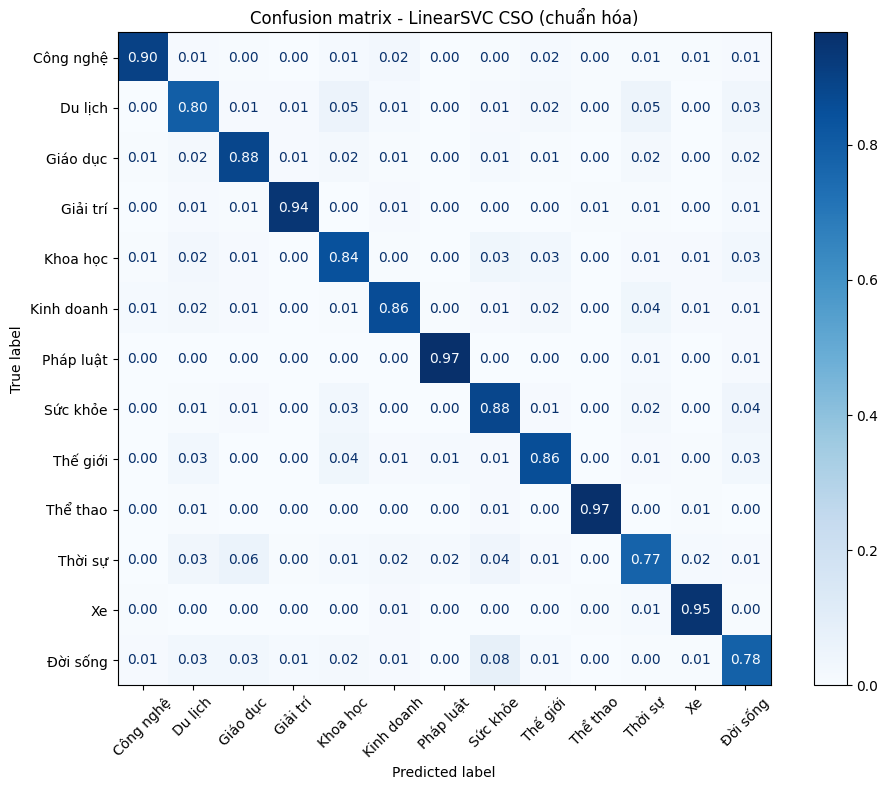

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


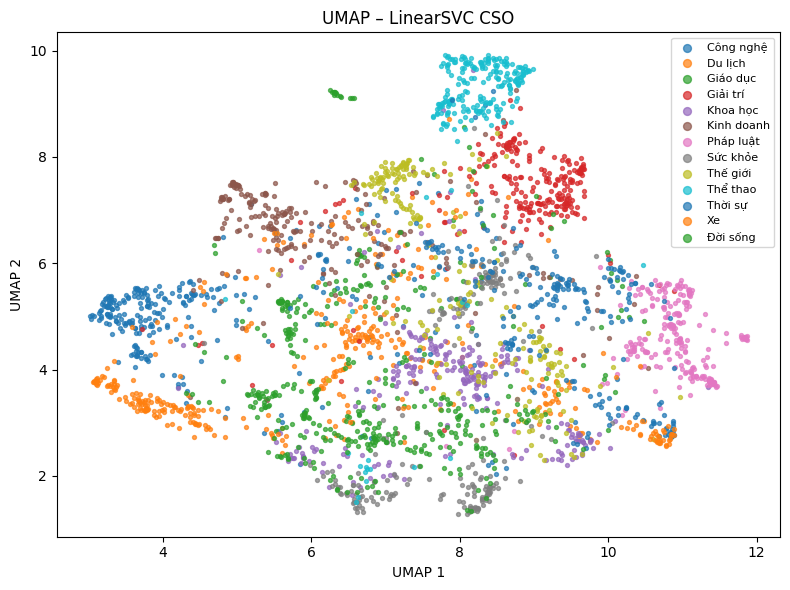

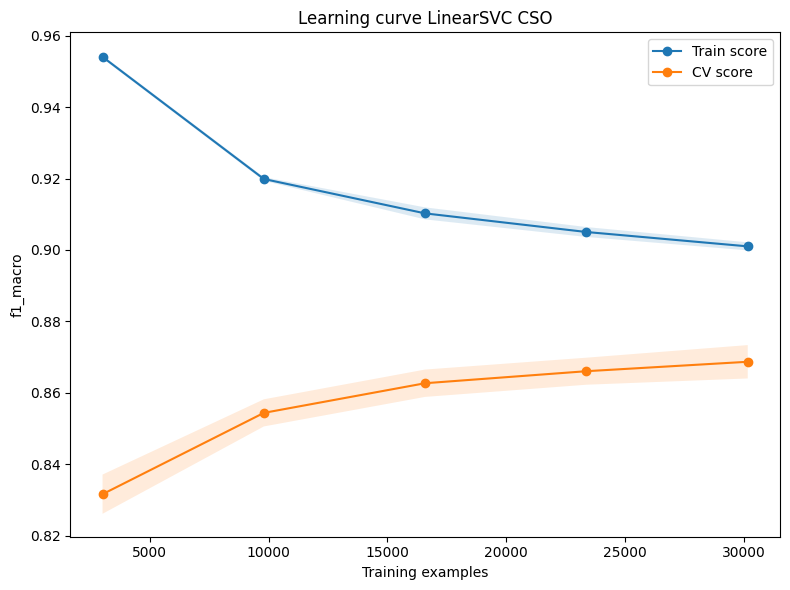

In [4]:
# ================== ĐÁNH GIÁ & TRỰC QUAN HÓA MODEL LINEAR ==================
import joblib
import numpy as np
from phobert_svm_pipeline import (    
    evaluate_confusion_matrix, plot_umap_embeddings,
    plot_learning_curve_svm
)
clf = joblib.load(f"{SAVE_MODEL_DIR}/linear_svc_cso.joblib")

X_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_train_emb.npy")
y_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_train.npy")
X_test  = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_test_emb.npy")
y_test_num  = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_test.npy")

LABEL_NAMES = [
    "Công nghệ",     # 0
    "Du lịch",       # 1
    "Giáo dục",      # 2
    "Giải trí",      # 3
    "Khoa học",      # 4
    "Kinh doanh",    # 5
    "Pháp luật",     # 6
    "Sức khỏe",      # 7
    "Thế giới",      # 8
    "Thể thao",      # 9
    "Thời sự",       # 10
    "Xe",            # 11
    "Đời sống",      # 12
]

# 1) Confusion matrix (dùng EMBEDDING đã lưu -> không embed lại)
evaluate_confusion_matrix(
    clf,
    X_emb=X_test,
    y_true_labels=y_test_num,
    normalize=True,
    title="Confusion matrix - LinearSVC CSO",
    label_names=LABEL_NAMES
)

# 2) UMAP (dùng EMBEDDING đã lưu)
# Lưu ý: cần cài umap-learn trước khi chạy:  pip install umap-learn
plot_umap_embeddings(
    X_emb=X_test,
    y_int=y_test_num,
    label_names=LABEL_NAMES,
    max_points=3000,
    title="UMAP – LinearSVC CSO"
)

# 3) Learning curve (trên EMBEDDING train đã lưu)
plot_learning_curve_svm(
    clf,
    X_emb=X_train,
    y_labels=y_train,
    scoring="f1_macro",
    title="Learning curve LinearSVC CSO"
)